In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk
import numpy as np
#print(tf.__version__)
#print(pd.__version__)
#print(sk.__version__)

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, ReLU

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight


In [45]:
df = pd.read_csv('./data/ai4i2020.csv')

# Create a new column for 'Machine functional'
df['Machine functional'] = 1 - df['Machine failure']

# Transform the Product ID column to a int column by removing the 'Product ' prefix and encoding the letter as a number
#first, transform the column to a string without the 'Product ' prefix
df['Product ID'] = df['Product ID'].str.replace('Product ', '')
#then, encode the letter as a number
df['Product ID'] = df['Product ID'].astype('category').cat.codes


# One-hot encode the 'Type' column
df = pd.get_dummies(df, columns=['Type'])

print(df.head())

   UDI  Product ID  Air temperature [K]  Process temperature [K]  \
0    1        7003                298.1                    308.6   
1    2        1003                298.2                    308.7   
2    3        1004                298.1                    308.5   
3    4        1005                298.2                    308.6   
4    5        1006                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  Machine functional  Type_H  Type_L  Type_M  
0    0    0    0    0               

In [46]:
Y = df[['Machine functional', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

# suppression des machines qui ont plusieurs pannes
filtered_df = df[Y.sum(axis=1) == 1]
X = filtered_df.drop(columns=['Product ID','Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
Y = filtered_df[['Machine functional', 'TWF', 'HDF', 'PWF', 'OSF']]

# Convertir Y en un seul label catégorisé
def label_encoding(row):
    if row['Machine functional'] == 1:
        return 1
    elif row['TWF'] == 1:
        return 2
    elif row['HDF'] == 1:
        return 3
    elif row['PWF'] == 1:
        return 4
    elif row['OSF'] == 1:
        return 5
    return 0

Y_single_label = Y.apply(label_encoding, axis=1)

#print(Y_single_label[:5])
print(Y_single_label.value_counts())
print(f'Number of elements in X: {len(X)}')

1    9643
3     106
4      80
5      78
2      42
Name: count, dtype: int64
Number of elements in X: 9949


In [47]:
# Appliquer SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X, Y_single_label)

# Reconvertir Y en format one-hot encoding
Y_resampled_one_hot = np.zeros((Y_resampled.shape[0], 5))
Y_resampled_one_hot[np.arange(Y_resampled.shape[0]), Y_resampled - 1] = 1

print(f'Number of elements in X_resampled: {len(X_resampled)}')


print(X_resampled[:5])

Number of elements in X_resampled: 48215
   UDI  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    1                298.1                    308.6                    1551   
1    2                298.2                    308.7                    1408   
2    3                298.1                    308.5                    1498   
3    4                298.2                    308.6                    1433   
4    5                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine functional  Type_H  Type_L  Type_M  
0         42.8                0                   1   False   False    True  
1         46.3                3                   1   False    True   False  
2         49.4                5                   1   False    True   False  
3         39.5                7                   1   False    True   False  
4         40.0                9                   1   False    True   False  


c:\Users\maure\OneDrive\Bureau\ISMIN\IA_manu_embarq\TP_IA_EMBARQUEE\myenv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [48]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled_one_hot, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# Print the number of elements in each set
print(f'Number of elements in X_train: {len(X_train)}')
print(f'Number of elements in X_test: {len(X_test)}')
print(f'Number of elements in X_val: {len(X_val)}')

Number of elements in X_train: 33750
Number of elements in X_test: 7233
Number of elements in X_val: 7232


In [49]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))
x = tf.keras.layers.Dense(512, activation='relu')(inputs)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = Dense(5, activation='softmax')(x)

my_model_mlp = tf.keras.Model(inputs, outputs, name = 'my_model_mlp')
my_model_mlp.summary()
my_model_mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "my_model_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,437 (697.02 KB)

 Trainable params: 178,437 (697.02 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
X_train = np.array(X_train, dtype=np.float32)
Y_train = np.array(Y_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
Y_val = np.array(Y_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
Y_test = np.array(Y_test, dtype=np.float32)

print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_val))
print(np.shape(Y_val))
print(np.shape(X_test))
print(np.shape(Y_test))
#print(X_train[:5])
#print(Y_train[:5])

(33750, 10)
(33750, 5)
(7232, 10)
(7232, 5)
(7233, 10)
(7233, 5)


Epoch 1/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2208 - loss: 34.2972 - val_accuracy: 0.2337 - val_loss: 1.5772
Epoch 2/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2280 - loss: 1.6313 - val_accuracy: 0.2463 - val_loss: 1.5492
Epoch 3/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2546 - loss: 1.5679 - val_accuracy: 0.3183 - val_loss: 1.4448
Epoch 4/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2917 - loss: 1.5010 - val_accuracy: 0.4110 - val_loss: 1.4001
Epoch 5/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3297 - loss: 1.4436 - val_accuracy: 0.4898 - val_loss: 1.2629
Epoch 6/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4053 - loss: 1.3531 - val_accuracy: 0.5093 - val_loss: 1.1447
Epoch 7/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4464 - loss: 1.2688 - val_accuracy: 0.5860 - val_loss: 0.9981
Epoch 8/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4956 - loss: 1.1111 - val_accuracy: 0

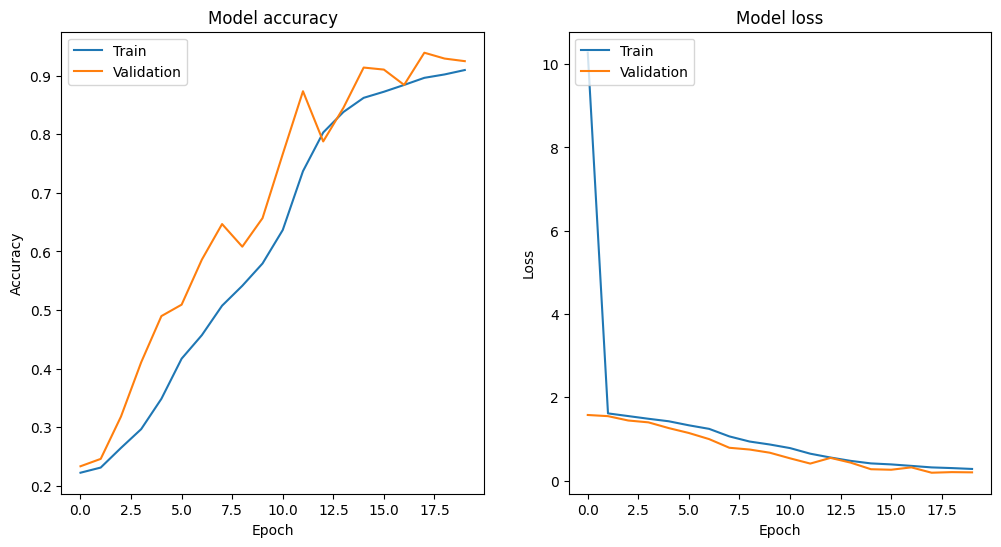

In [51]:
nb_epochs = 20
batch_size = 70

training_history = my_model_mlp.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_model_mlp.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_model_mlp.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)
print("Performance on the TRAIN set, LOSS=",loss_train)
print("Performance on the TEST set, LOSS=",loss_test)   

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      1502
           1       0.88      0.94      0.91      1431
           2       0.95      0.99      0.97      1451
           3       0.95      0.93      0.94      1446
           4       0.91      0.99      0.95      1403

    accuracy                           0.93      7233
   macro avg       0.93      0.93      0.93      7233
weighted avg       0.93      0.93      0.93      7233



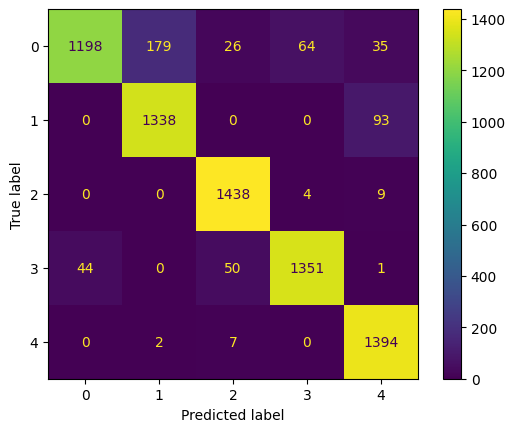

In [52]:
disp = ConfusionMatrixDisplay(confusion_matrix(Y_test.argmax(axis=1), my_model_mlp.predict(X_test).argmax(axis=1)))
disp.plot()
report = classification_report(Y_test.argmax(axis=1), my_model_mlp.predict(X_test).argmax(axis=1))
print(report)

In [53]:
#save the model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(my_model_mlp)
tflite_model = converter.convert()
open("neural_network.tflite", "wb").write(tflite_model)

np.save('data/X_test.npy', X_test)
np.save('data/Y_test.npy', Y_test)

INFO:tensorflow:Assets written to: C:\Users\maure\AppData\Local\Temp\tmpwfwvwcte\assets


INFO:tensorflow:Assets written to: C:\Users\maure\AppData\Local\Temp\tmpwfwvwcte\assets


Saved artifact at 'C:\Users\maure\AppData\Local\Temp\tmpwfwvwcte'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='keras_tensor_40')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2093369221536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2093369222064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2093433095968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2093554295376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2093555052032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2093555068240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2093555068768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2093555076784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2093555134304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2093555120256: TensorSpec(shape=(), dtype=tf.resource, name=None)
